# Machine Learning and Data Mining Coursework
#### Submitted by:
##### Shubham Kandpal || sk02593@surrey.ac.uk || 6812009

## 1. Comparing ML models on Bank churners dataset

In [1]:
# Important libraries to import
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, cross_val_predict
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import xgboost as xgb
from sklearn.preprocessing import label_binarize

# Loading bank churner's dataset
dataset = pd.read_csv('BankChurners.csv')
dataset.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


### a. Preprocessing of Bank dataset

In [ ]:
# Checking for duplicate records in the dataset
duplicate_rows = dataset[dataset.duplicated()]

if duplicate_rows.shape[0] > 0:
    print("Duplicate records found.")
    print(duplicate_rows)
else:
    print("No duplicate records found.")

No duplicate records found.


In [ ]:
# List of columns to remove
columns_to_remove = ['CLIENTNUM',
                     'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                     'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

# Remove the selected columns
dataset = dataset.drop(columns=columns_to_remove)
dataset.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [ ]:
# Get the data types of each column
column_data_types = dataset.dtypes

# Initialize empty lists to store numeric and non-numeric column names
numeric_columns = []
symbolic_columns = []

# Iterate through each column and categorize based on data type
for column_name, dtype in column_data_types.items():
    if pd.api.types.is_numeric_dtype(dtype):
        numeric_columns.append(column_name)
    else:
        symbolic_columns.append(column_name)

# Print the results
print("Numeric Columns:\n", numeric_columns)
print("\nSymbolic Columns:\n", symbolic_columns)

# Create numeric and symbolic dataset
numeric_data = dataset[numeric_columns]
symbolic_data = dataset[symbolic_columns]

Numeric Columns:
 ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

Symbolic Columns:
 ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


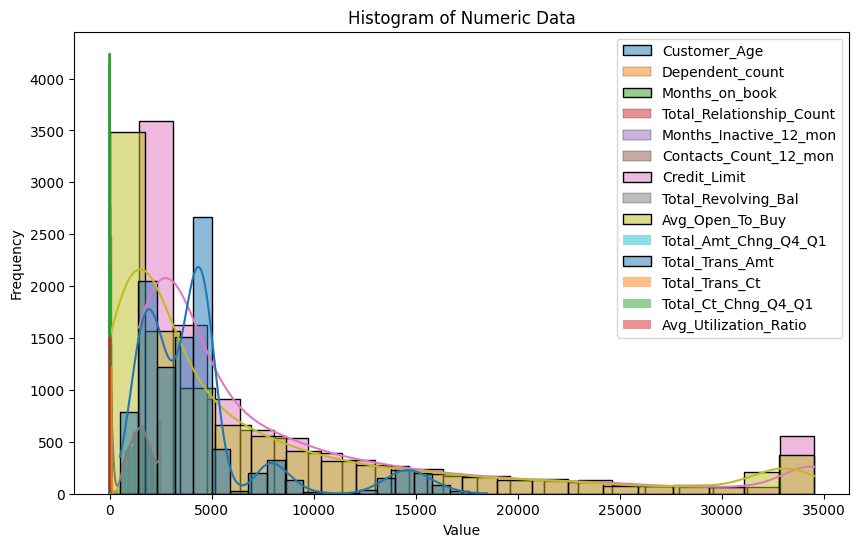

<ipython-input-5-dbe668eb49b3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=symbolic_data, x=column, palette='viridis')
<ipython-input-5-dbe668eb49b3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=symbolic_data, x=column, palette='viridis')
<ipython-input-5-dbe668eb49b3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=symbolic_data, x=column, palette='viridis')
<ipython-input-5-dbe668eb49b3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the 

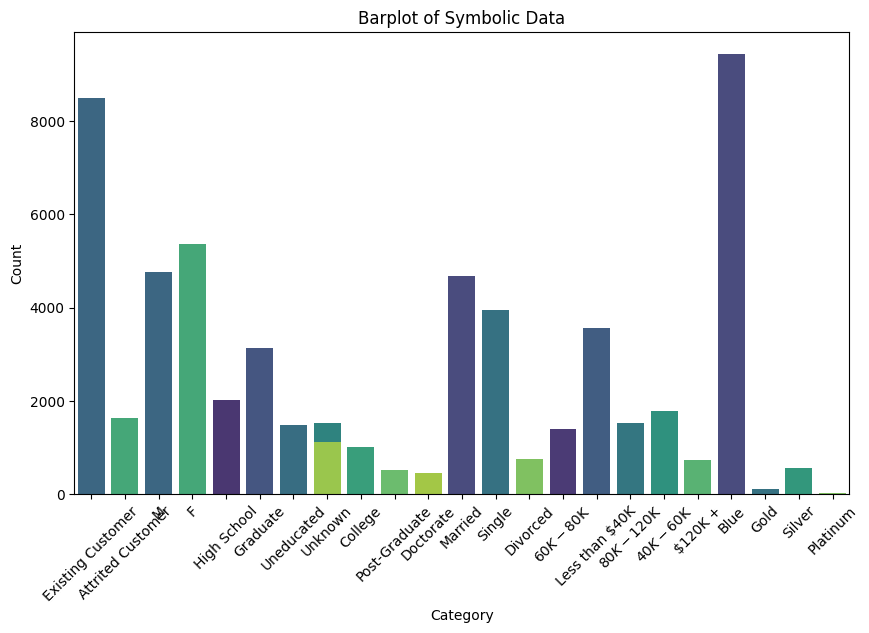

In [ ]:
# Plot histogram for numeric data
plt.figure(figsize=(10, 6))
for column in numeric_data.columns:
    sns.histplot(numeric_data[column], bins=20, kde=True, label=column, alpha=0.5)
plt.title('Histogram of Numeric Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot barplot for symbolic data
plt.figure(figsize=(10, 6))
for column in symbolic_data.columns:
    sns.countplot(data=symbolic_data, x=column, palette='viridis')
plt.title('Barplot of Symbolic Data')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

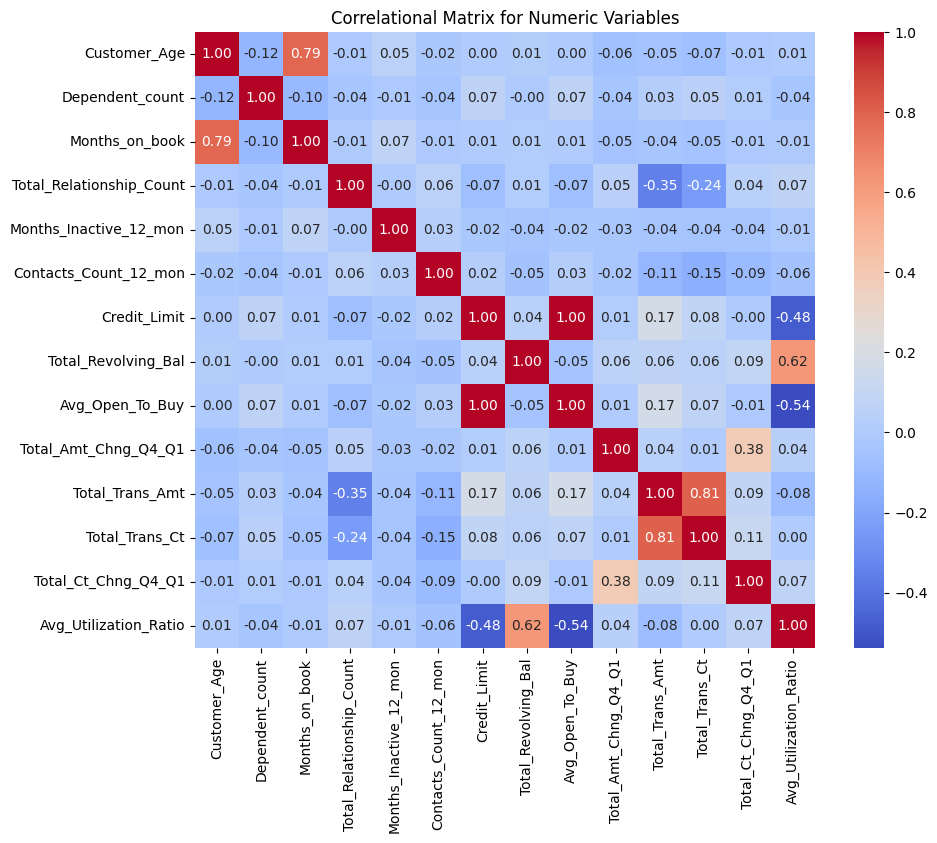

In [ ]:
# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the correlational matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlational Matrix for Numeric Variables')
plt.show()

In [ ]:
# Count 'Unknowns' in each column
unknown_counts = (dataset == 'Unknown').sum()
print("Unknown counts in each column:\n\n", unknown_counts)

# Identify columns with 'Unknown' values
columns_with_unknowns = unknown_counts[unknown_counts > 0].index.tolist()

# Remove rows with 'Unknown' values in identified columns
dataset_cleaned = dataset[~dataset[columns_with_unknowns].apply(lambda x: x.str.contains('Unknown')).any(axis=1)]

Unknown counts in each column:

 Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category             1112
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64


In [ ]:
# One-hot encode 'Marital_Status'
marital_status_encoded = pd.get_dummies(dataset_cleaned['Marital_Status'], prefix='Marital_Status')
marital_status_encoded = marital_status_encoded.astype(int)

# Concatenate the encoded columns with the original dataset
dataset_encoded = pd.concat([dataset_cleaned, marital_status_encoded], axis=1)

# Drop the original 'Marital_Status' column
dataset_encoded.drop(columns=['Marital_Status'], inplace=True)

In [ ]:
# Define the hierarchical mapping
education_level_mapping = {
    "Uneducated": 0,
    "High School": 1,
    "College": 2,
    "Graduate": 3,
    "Post-Graduate": 4,
    "Doctorate": 5
}
income_category_mapping = {
    "Less than $40K": 0,
    "$40K - $60K": 1,
    "$60K - $80K": 2,
    "$80K - $120K": 3,
    "$120K +": 4
}
card_category_mapping = {
    "Blue": 0,
    "Silver": 1,
    "Gold": 2,
    "Platinum": 3
}
gender_mapping = {
    "F": 0,
    "M": 1
}
attrition_flag_mapping = {
    "Attrited Customer": 0,
    "Existing Customer": 1
}

# Convert 'Education_Level' to numeric based on the hierarchical mapping
dataset_encoded['Education_Level'] = dataset_encoded['Education_Level'].map(education_level_mapping)
dataset_encoded['Income_Category'] = dataset_encoded['Income_Category'].map(income_category_mapping)
dataset_encoded['Card_Category'] = dataset_encoded['Card_Category'].map(card_category_mapping)
dataset_encoded['Gender'] = dataset_encoded['Gender'].map(gender_mapping)
dataset_encoded['Attrition_Flag'] = dataset_encoded['Attrition_Flag'].map(attrition_flag_mapping)

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns to normalize
columns_to_log = ['Credit_Limit', 'Avg_Open_To_Buy', 'Total_Trans_Amt', 'Total_Amt_Chng_Q4_Q1']
columns_to_sqrt = ['Total_Ct_Chng_Q4_Q1', 'Total_Revolving_Bal']
column_to_arcsine_sqrt = ['Avg_Utilization_Ratio']
columns_to_zscale = ['Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1',
                     'Total_Trans_Amt', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

# Apply transformations
dataset_encoded[columns_to_log] = np.log1p(dataset_encoded[columns_to_log])
dataset_encoded[columns_to_sqrt] = np.sqrt(dataset_encoded[columns_to_sqrt])
dataset_encoded[column_to_arcsine_sqrt] = np.arcsin(np.sqrt(dataset_encoded[column_to_arcsine_sqrt]))
dataset_encoded[columns_to_zscale] = scaler.fit_transform(dataset_encoded[columns_to_zscale])

dataset_encoded.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single
0,1,45,1,3,1,2,0,39,5,1,...,-0.078173,0.954884,2.428831,-1.660378,42,3.219802,-0.610829,0,1,0
1,1,49,0,5,3,0,0,44,6,1,...,0.007879,0.593841,3.137627,-1.479605,33,7.966868,-0.398436,0,0,1
2,1,51,1,3,3,3,0,36,4,1,...,-1.657130,0.010450,6.044279,-0.911894,20,5.058190,-1.269865,0,1,0
4,1,40,1,3,0,2,0,21,5,1,...,-1.657130,0.253906,5.005067,-2.165522,28,5.449081,-1.269865,0,1,0
5,1,44,1,2,3,1,0,36,3,1,...,0.343160,-0.150431,2.574760,-1.735427,24,0.636989,0.292349,0,1,0


In [ ]:
dataset_encoded.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single'],
      dtype='object')

In [ ]:
# Features
X = dataset_encoded.drop('Attrition_Flag', axis=1)
# Target Variable
y = dataset_encoded['Attrition_Flag']

# Using smote for data balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Original class distribution:")
print(y.value_counts())

print("\nClass distribution after SMOTE:")
print(y_resampled.value_counts())

Original class distribution:
Attrition_Flag
1    5968
0    1113
Name: count, dtype: int64

Class distribution after SMOTE:
Attrition_Flag
1    5968
0    5968
Name: count, dtype: int64


In [ ]:
# Split the data into training and temporary sets (80% training, 20% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Split the temporary set into testing and validation sets (50% testing, 50% validation of the temporary set)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("Validation set size:", X_val.shape)

Training set size: (9548, 21)
Testing set size: (1194, 21)
Validation set size: (1194, 21)


### b. Naive Bayes for Bank Churners dataset

In [ ]:
# Initialize the Gaussian Naive Bayes model
gnb = GaussianNB()

# Perform cross-validation on the training set
cv_scores = cross_val_score(gnb, X_train, y_train, cv=5, scoring='accuracy')

# Fit the model on the training set
gnb.fit(X_train, y_train)

GaussianNB()

Cross-validation scores: [0.81204188 0.81937173 0.81675393 0.83184914 0.80932425]
Mean cross-validation score: 0.817868185695205
Classification Report of Naive Bayes on Validation Set:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       597
           1       0.83      0.78      0.81       597

    accuracy                           0.81      1194
   macro avg       0.81      0.81      0.81      1194
weighted avg       0.81      0.81      0.81      1194



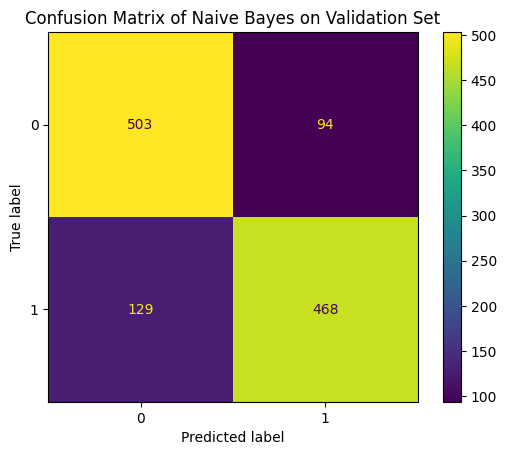

ROC-AUC Score of Naive Bayes on Validation Set: 0.889054429040793


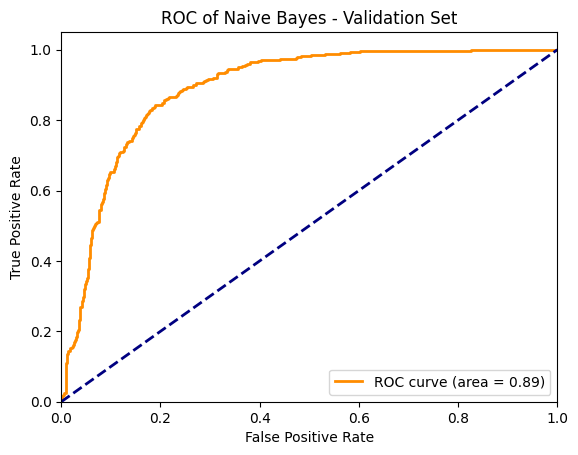

In [ ]:
# Predict on the validation set
y_val_pred = gnb.predict(X_val)
y_val_pred_prob = gnb.predict_proba(X_val)[:, 1]

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# Evaluate the model
print("Classification Report of Naive Bayes on Validation Set:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix of Naive Bayes on Validation Set")
plt.show()

# ROC-AUC Score and Curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score of Naive Bayes on Validation Set:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Naive Bayes - Validation Set')
plt.legend(loc="lower right")
plt.show()

Classification Report of Naive Bayes on Test Set:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       597
           1       0.84      0.78      0.81       597

    accuracy                           0.81      1194
   macro avg       0.82      0.81      0.81      1194
weighted avg       0.82      0.81      0.81      1194



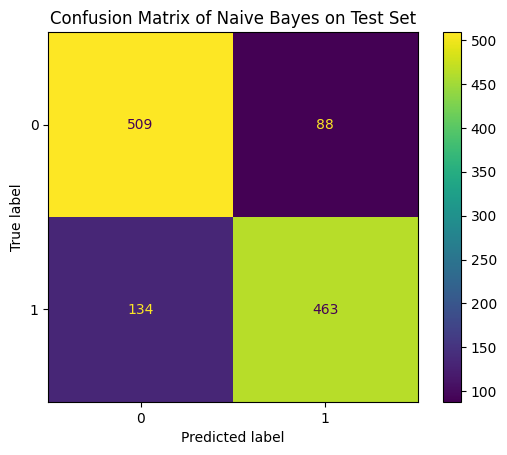

ROC-AUC Score of Naive Bayes on Test Set: 0.8980777702022116


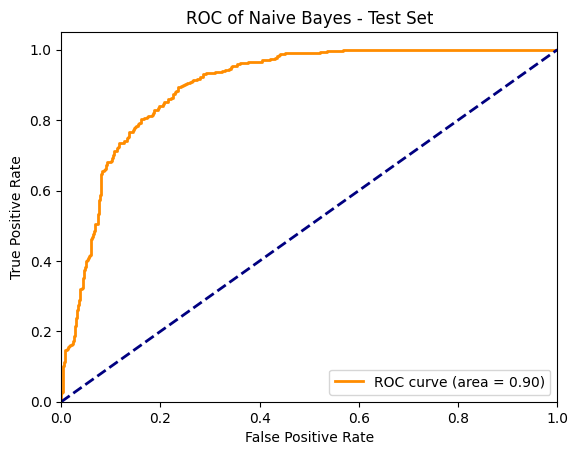

In [ ]:
# Predict on the test set
y_test_pred = gnb.predict(X_test)
y_test_pred_prob = gnb.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report of Naive Bayes on Test Set:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.title("Confusion Matrix of Naive Bayes on Test Set")
plt.show()

# ROC-AUC Score and Curve
fpr_nb_bank, tpr_nb_bank, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc_test = auc(fpr_nb_bank, tpr_nb_bank)
print("ROC-AUC Score of Naive Bayes on Test Set:", roc_auc_test)

plt.figure()
plt.plot(fpr_nb_bank, tpr_nb_bank, color='darkorange', lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Naive Bayes - Test Set')
plt.legend(loc="lower right")
plt.show()

### c. CNN for Bank Churners dataset

In [ ]:
# Define the model
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
299/299 [==============================] - 9s 7ms/step - loss: 0.6296 - accuracy: 0.7153 - val_loss: 0.4233 - val_accuracy: 0.7881
Epoch 2/50
299/299 [==============================] - 2s 6ms/step - loss: 0.4213 - accuracy: 0.8117 - val_loss: 0.3873 - val_accuracy: 0.8350
Epoch 3/50
299/299 [==============================] - 2s 6ms/step - loss: 0.3659 - accuracy: 0.8464 - val_loss: 0.3973 - val_accuracy: 0.8141
Epoch 4/50
299/299 [==============================] - 2s 6ms/step - loss: 0.3346 - accuracy: 0.8579 - val_loss: 0.2261 - val_accuracy: 0.9104
Epoch 5/50
299/299 [==============================] - 2s 7ms/step - loss: 0.3052 - accuracy: 0.8795 - val_loss: 0.2258 - val_accuracy: 0.9028
Epoch 6/50
299/299 [==============================] - 2s 8ms/step - loss: 0.2955 - accuracy: 0.8788 - val_loss: 0.2376 - val_accuracy: 0.9070
Epoch 7/50
299/299 [==============================] - 2s 6ms/step - loss: 0.2823 - accuracy: 0.8857 - val_loss: 0.2135 - val_accuracy: 0.9112
Epoch 

38/38 [==============================] - 0s 2ms/step
Classification Report of CNN on Validation Set:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       597
           1       0.95      0.93      0.94       597

    accuracy                           0.94      1194
   macro avg       0.94      0.94      0.94      1194
weighted avg       0.94      0.94      0.94      1194



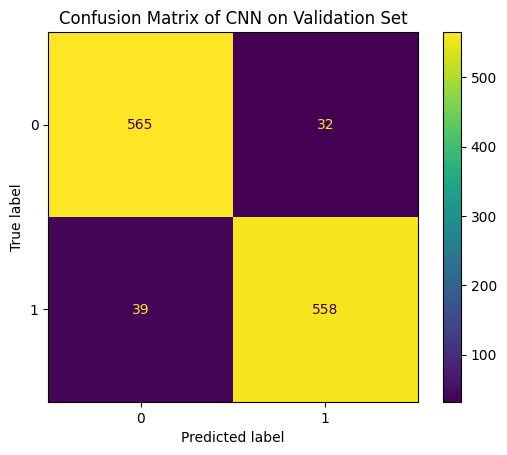

ROC-AUC Score of CNN on Validation Set: 0.985090163267482


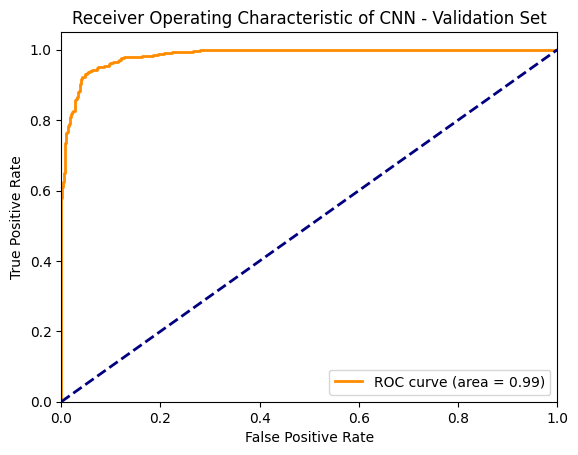

In [ ]:
# Predict on the validation set
y_val_pred_prob = model.predict(X_val)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Classification Report
print("Classification Report of CNN on Validation Set:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix of CNN on Validation Set")
plt.show()

# ROC-AUC Score and Curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score of CNN on Validation Set:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of CNN - Validation Set')
plt.legend(loc="lower right")
plt.show()

38/38 [==============================] - 0s 2ms/step
Classification Report of CNN on Test Set:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       597
           1       0.95      0.93      0.94       597

    accuracy                           0.94      1194
   macro avg       0.94      0.94      0.94      1194
weighted avg       0.94      0.94      0.94      1194



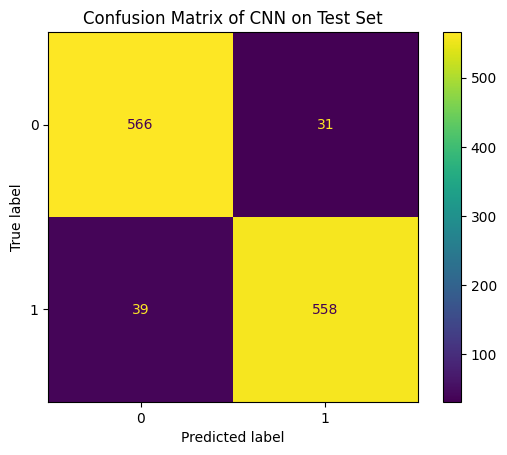

ROC-AUC Score of CNN on Test Set: 0.9851518901037853


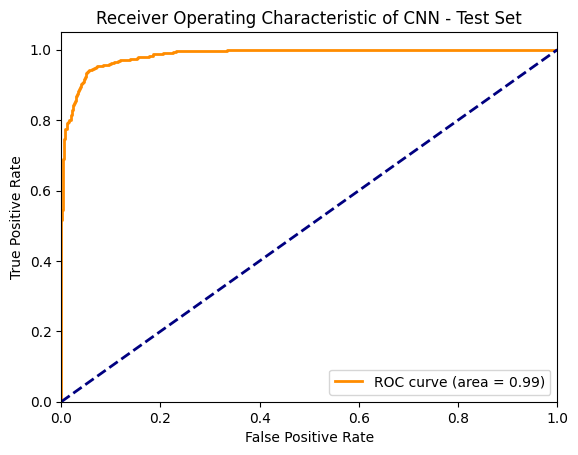

In [ ]:
# Predict on the test set
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Classification Report
print("Classification Report of CNN on Test Set:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.title("Confusion Matrix of CNN on Test Set")
plt.show()

# ROC-AUC Score and Curve
fpr_cnn_bank, tpr_cnn_bank, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc_test = auc(fpr_cnn_bank, tpr_cnn_bank)
print("ROC-AUC Score of CNN on Test Set:", roc_auc_test)

plt.figure()
plt.plot(fpr_cnn_bank, tpr_cnn_bank, color='darkorange', lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of CNN - Test Set')
plt.legend(loc="lower right")
plt.show()

### d. Random Forest for Bank Churners dataset

In [ ]:
# Initialize the Random Forest model
random_forest = RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1)

# Train the model
random_forest.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

Classification Report of Random Forest on Validation Set:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       597
           1       0.98      0.97      0.98       597

    accuracy                           0.98      1194
   macro avg       0.98      0.98      0.98      1194
weighted avg       0.98      0.98      0.98      1194



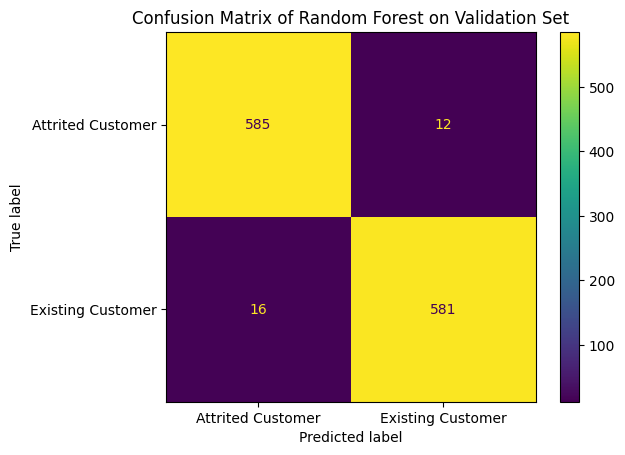

ROC-AUC Score of Random Forest on Validation Set: 0.9979054962136198


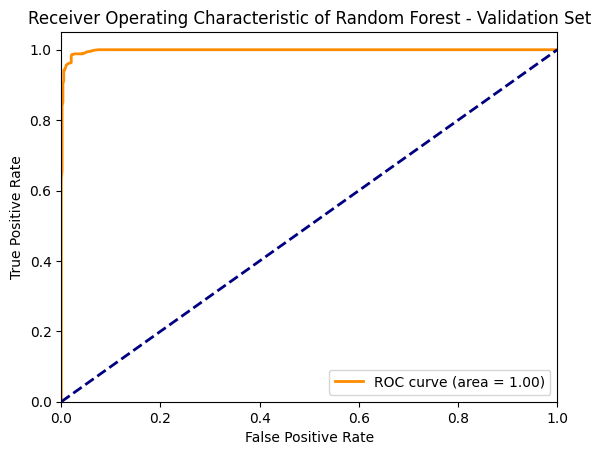

In [ ]:
# Predict on the validation set
y_val_pred = random_forest.predict(X_val)
y_val_pred_prob = random_forest.predict_proba(X_val)[:, 1]

# Classification Report
print("Classification Report of Random Forest on Validation Set:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Attrited Customer', 'Existing Customer'])
disp.plot()
plt.title("Confusion Matrix of Random Forest on Validation Set")
plt.show()

# ROC-AUC Score and Curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score of Random Forest on Validation Set:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Random Forest - Validation Set')
plt.legend(loc="lower right")
plt.show()

Classification Report of Random Forest on Test Set:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       597
           1       0.99      0.98      0.98       597

    accuracy                           0.98      1194
   macro avg       0.98      0.98      0.98      1194
weighted avg       0.98      0.98      0.98      1194



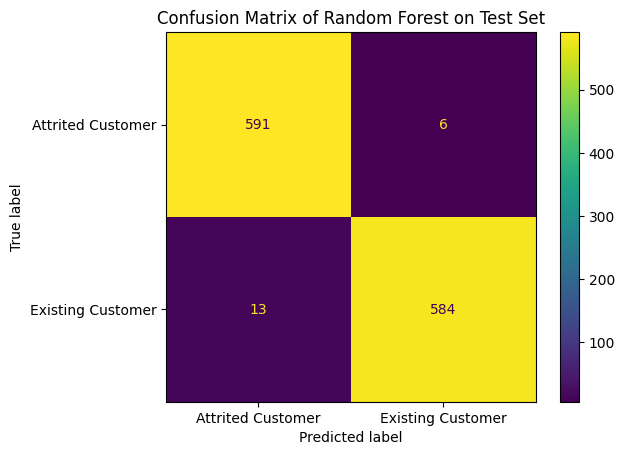

ROC-AUC Score of Random Forest on Test Set: 0.9983894907255428


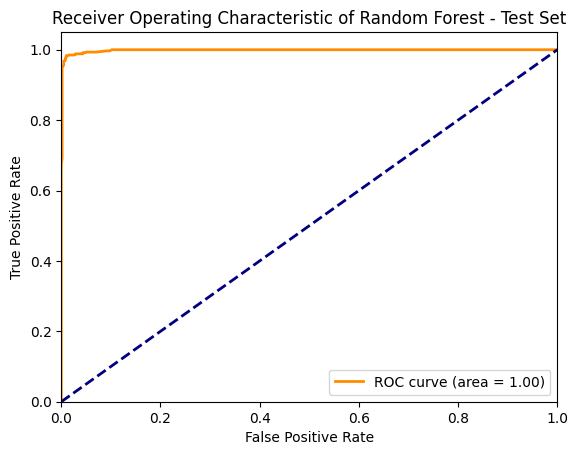

In [ ]:
# Predict on the test set
y_test_pred = random_forest.predict(X_test)
y_test_pred_prob = random_forest.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report of Random Forest on Test Set:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Attrited Customer', 'Existing Customer'])
disp_test.plot()
plt.title("Confusion Matrix of Random Forest on Test Set")
plt.show()

# ROC-AUC Score and Curve
fpr_rf_bank, tpr_rf_bank, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc_test = auc(fpr_rf_bank, tpr_rf_bank)
print("ROC-AUC Score of Random Forest on Test Set:", roc_auc_test)

plt.figure()
plt.plot(fpr_rf_bank, tpr_rf_bank, color='darkorange', lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Random Forest - Test Set')
plt.legend(loc="lower right")
plt.show()

### e. XgBoost on Bank Churner dataset

In [ ]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       597
           1       0.99      0.98      0.98       597

    accuracy                           0.98      1194
   macro avg       0.98      0.98      0.98      1194
weighted avg       0.98      0.98      0.98      1194



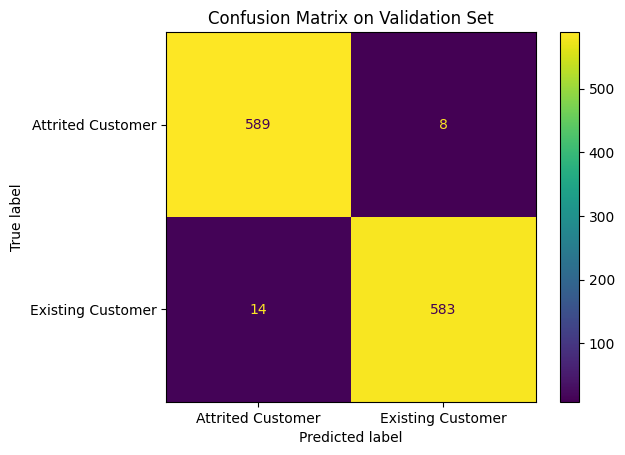

ROC-AUC Score on Validation Set: 0.9991610761793333


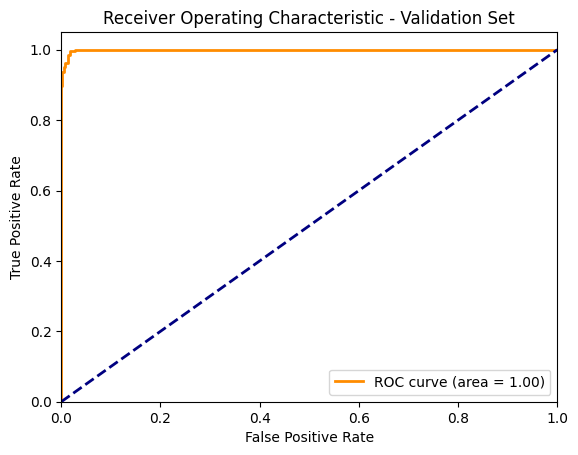

In [ ]:
# Predict on the validation set
y_val_pred = xgb_model.predict(X_val)
y_val_pred_prob = xgb_model.predict_proba(X_val)[:, 1]

# Classification Report
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Attrited Customer', 'Existing Customer'])
disp.plot()
plt.title("Confusion Matrix on Validation Set")
plt.show()

# ROC-AUC Score and Curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score on Validation Set:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Validation Set')
plt.legend(loc="lower right")
plt.show()

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       597
           1       0.99      0.99      0.99       597

    accuracy                           0.99      1194
   macro avg       0.99      0.99      0.99      1194
weighted avg       0.99      0.99      0.99      1194



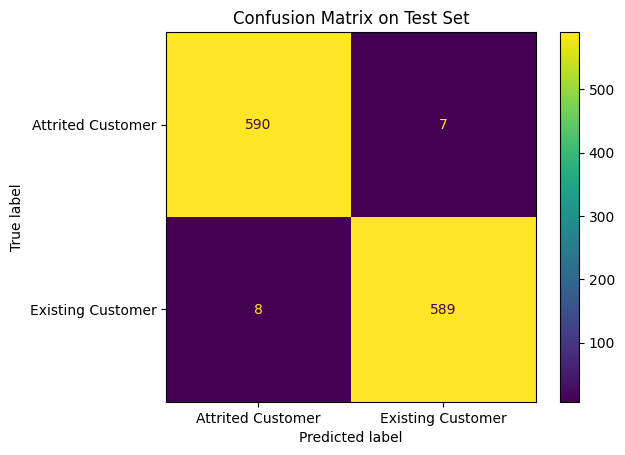

ROC-AUC Score on Test Set: 0.9989394207216988


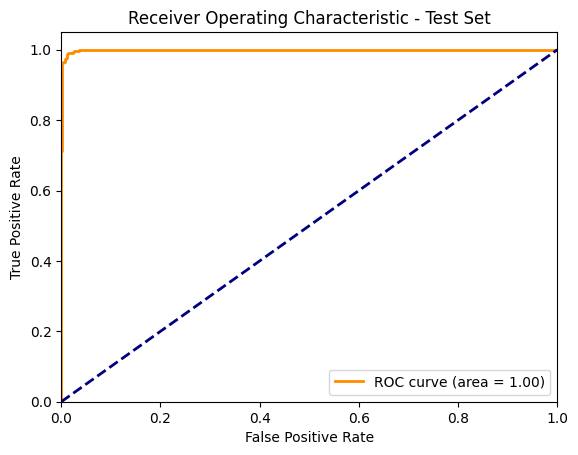

In [ ]:
# Predict on the test set
y_test_pred = xgb_model.predict(X_test)
y_test_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Attrited Customer', 'Existing Customer'])
disp.plot()
plt.title("Confusion Matrix on Test Set")
plt.show()

# ROC-AUC Score and Curve
fpr_xgb_bank, tpr_xgb_bank, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr_xgb_bank, tpr_xgb_bank)
print("ROC-AUC Score on Test Set:", roc_auc)

plt.figure()
plt.plot(fpr_xgb_bank, tpr_xgb_bank, color='darkorange', lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc="lower right")
plt.show()

## 2. Comparing ML models on CIFAR-10 dataset

### a. Loading CIFAR-10 dataset

In [ ]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode the target variables
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

170498071/170498071 [==============================] - 3s 0us/step
Training set size: (40000, 32, 32, 3)
Validation set size: (10000, 32, 32, 3)
Test set size: (10000, 32, 32, 3)


### b. CNN for CIFAR-10

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64, callbacks=[early_stopping])

Epoch 1/20
625/625 [==============================] - 11s 9ms/step - loss: 1.8618 - accuracy: 0.3765 - val_loss: 1.9355 - val_accuracy: 0.3478
Epoch 2/20
625/625 [==============================] - 5s 7ms/step - loss: 1.3549 - accuracy: 0.5161 - val_loss: 1.2900 - val_accuracy: 0.5261
Epoch 3/20
625/625 [==============================] - 5s 7ms/step - loss: 1.2184 - accuracy: 0.5662 - val_loss: 1.1215 - val_accuracy: 0.6058
Epoch 4/20
625/625 [==============================] - 5s 8ms/step - loss: 1.1213 - accuracy: 0.6026 - val_loss: 2.0392 - val_accuracy: 0.4025
Epoch 5/20
625/625 [==============================] - 4s 7ms/step - loss: 1.0562 - accuracy: 0.6265 - val_loss: 1.6651 - val_accuracy: 0.4806
Epoch 6/20
625/625 [==============================] - 4s 7ms/step - loss: 0.9973 - accuracy: 0.6480 - val_loss: 0.9738 - val_accuracy: 0.6656
Epoch 7/20
625/625 [==============================] - 5s 8ms/step - loss: 0.9558 - accuracy: 0.6670 - val_loss: 1.0156 - val_accuracy: 0.6285
Epoch

313/313 [==============================] - 1s 2ms/step
Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       973
           1       0.92      0.85      0.88       979
           2       0.81      0.54      0.65      1030
           3       0.59      0.62      0.60      1023
           4       0.68      0.81      0.74       933
           5       0.64      0.70      0.67      1015
           6       0.73      0.90      0.80       996
           7       0.88      0.73      0.80       994
           8       0.81      0.89      0.85      1017
           9       0.88      0.85      0.86      1040

    accuracy                           0.76     10000
   macro avg       0.77      0.77      0.76     10000
weighted avg       0.77      0.76      0.76     10000



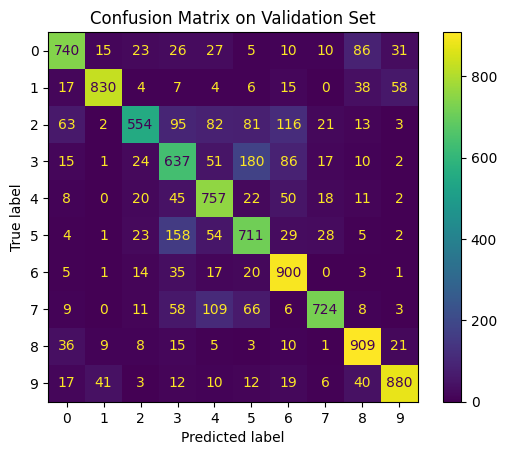

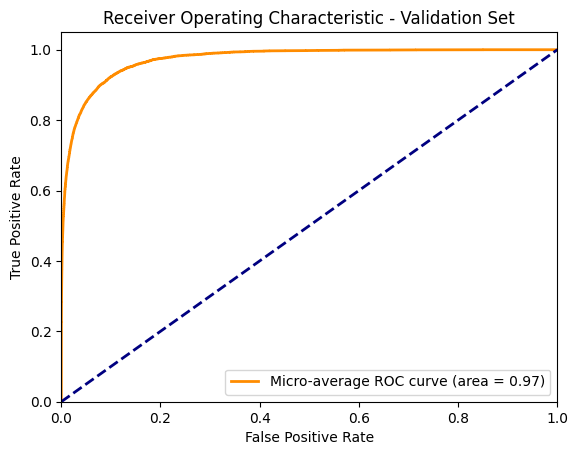

In [ ]:
# Predict on the validation set
y_val_pred_prob = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
y_val_true = np.argmax(y_val, axis=1)

# Classification Report
print("Classification Report on Validation Set:")
print(classification_report(y_val_true, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val_true, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot()
plt.title("Confusion Matrix on Validation Set")
plt.show()

# ROC-AUC Score and Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_val_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=2, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Validation Set')
plt.legend(loc="lower right")
plt.show()

313/313 [==============================] - 1s 4ms/step
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1000
           1       0.92      0.84      0.88      1000
           2       0.82      0.52      0.64      1000
           3       0.58      0.63      0.60      1000
           4       0.67      0.78      0.72      1000
           5       0.66      0.70      0.68      1000
           6       0.71      0.91      0.80      1000
           7       0.86      0.72      0.78      1000
           8       0.81      0.91      0.86      1000
           9       0.86      0.84      0.85      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



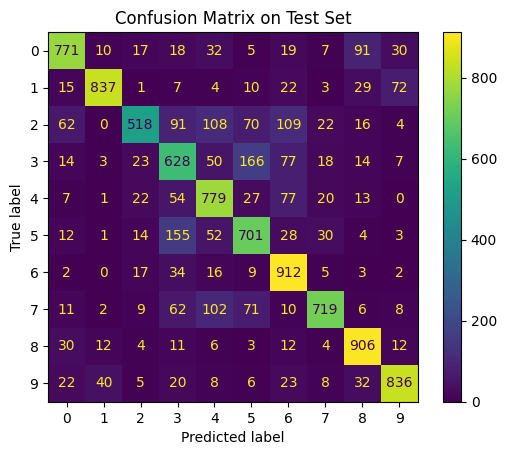

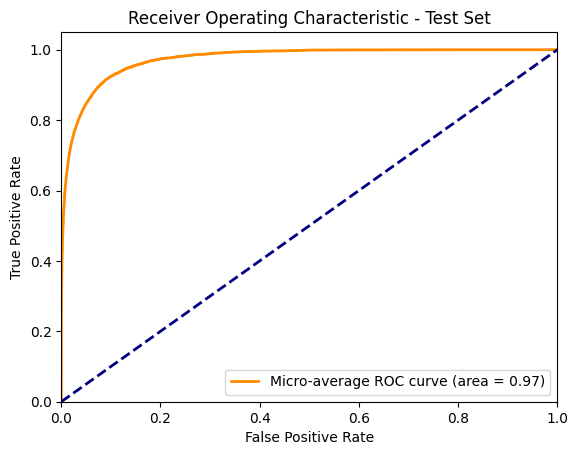

In [ ]:
# Predict on the test set
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report on Test Set:")
print(classification_report(y_test_true, y_test_pred))

# Confusion Matrix
cm_test = confusion_matrix(y_test_true, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=range(10))
disp_test.plot()
plt.title("Confusion Matrix on Test Set")
plt.show()

# ROC-AUC Score and Curve
fpr_cnn_cifar = {}
tpr_cnn_cifar = {}
roc_auc = {}

for i in range(10):
    fpr_cnn_cifar[i], tpr_cnn_cifar[i], _ = roc_curve(y_test[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr_cnn_cifar[i], tpr_cnn_cifar[i])

# Compute micro-average ROC curve and ROC area
fpr_cnn_cifar["micro"], tpr_cnn_cifar["micro"], _ = roc_curve(y_test.ravel(), y_test_pred_prob.ravel())
roc_auc["micro"] = auc(fpr_cnn_cifar["micro"], tpr_cnn_cifar["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr_cnn_cifar["micro"], tpr_cnn_cifar["micro"], color='darkorange', lw=2, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc="lower right")
plt.show()

### c. Naive Bayes on CIFAR-10

In [ ]:
# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Initialize the Gaussian Naive Bayes model
gnb = GaussianNB()

# Train the model
gnb.fit(X_train_flat, y_train.argmax(axis=1))

GaussianNB()

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.25      0.45      0.32       973
           1       0.32      0.15      0.20       979
           2       0.21      0.08      0.11      1030
           3       0.23      0.07      0.11      1023
           4       0.23      0.44      0.30       933
           5       0.30      0.25      0.27      1015
           6       0.26      0.48      0.33       996
           7       0.37      0.12      0.18       994
           8       0.37      0.43      0.40      1017
           9       0.38      0.39      0.38      1040

    accuracy                           0.28     10000
   macro avg       0.29      0.29      0.26     10000
weighted avg       0.29      0.28      0.26     10000



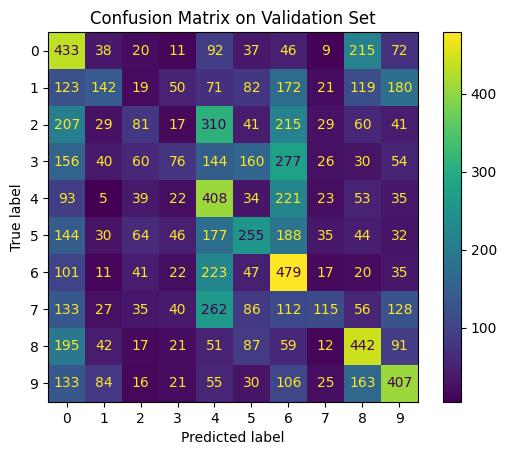

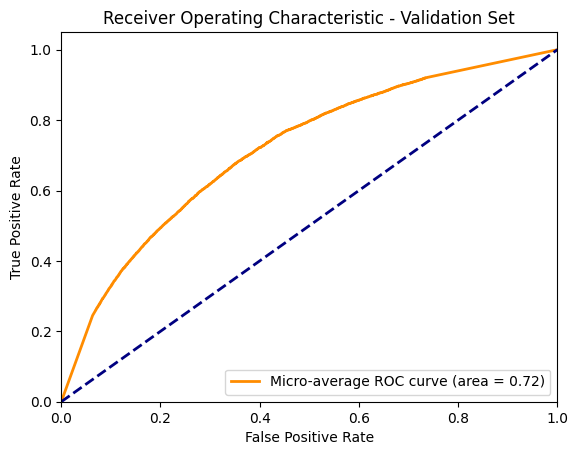

In [ ]:
# Predict on the validation set
y_val_pred = gnb.predict(X_val_flat)
y_val_pred_prob = gnb.predict_proba(X_val_flat)

# Evaluate the model
print("Classification Report on Validation Set:")
print(classification_report(y_val.argmax(axis=1), y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val.argmax(axis=1), y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot()
plt.title("Confusion Matrix on Validation Set")
plt.show()

# ROC-AUC Score and Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_val_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=2, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Validation Set')
plt.legend(loc="lower right")
plt.show()

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.27      0.49      0.35      1000
           1       0.40      0.17      0.24      1000
           2       0.18      0.08      0.11      1000
           3       0.25      0.07      0.12      1000
           4       0.24      0.42      0.30      1000
           5       0.32      0.27      0.29      1000
           6       0.25      0.46      0.33      1000
           7       0.42      0.13      0.19      1000
           8       0.39      0.48      0.43      1000
           9       0.38      0.40      0.39      1000

    accuracy                           0.30     10000
   macro avg       0.31      0.30      0.27     10000
weighted avg       0.31      0.30      0.27     10000



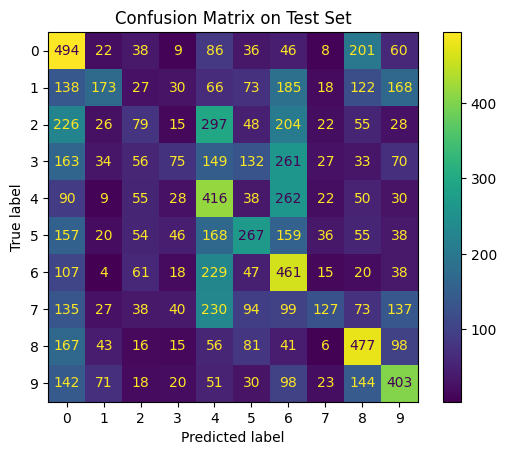

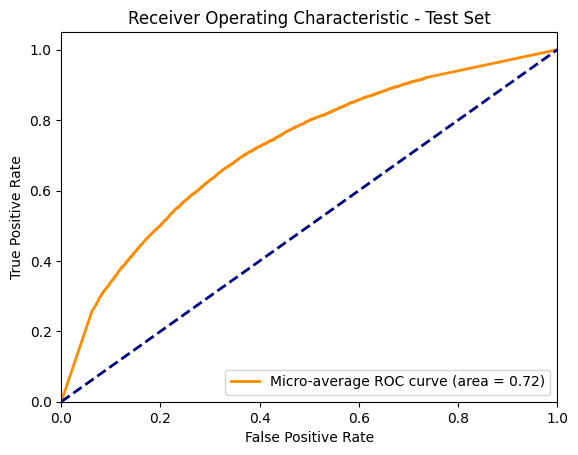

In [ ]:
# Predict on the test set
y_test_pred = gnb.predict(X_test_flat)
y_test_pred_prob = gnb.predict_proba(X_test_flat)

# Evaluate the model
print("Classification Report on Test Set:")
print(classification_report(y_test.argmax(axis=1), y_test_pred))

# Confusion Matrix
cm_test = confusion_matrix(y_test.argmax(axis=1), y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=range(10))
disp_test.plot()
plt.title("Confusion Matrix on Test Set")
plt.show()

# ROC-AUC Score and Curve
fpr_nb_cifar = {}
tpr_nb_cifar = {}
roc_auc = {}

for i in range(10):
    fpr_nb_cifar[i], tpr_nb_cifar[i], _ = roc_curve(y_test[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr_nb_cifar[i], tpr_nb_cifar[i])

# Compute micro-average ROC curve and ROC area
fpr_nb_cifar["micro"], tpr_nb_cifar["micro"], _ = roc_curve(y_test.ravel(), y_test_pred_prob.ravel())
roc_auc["micro"] = auc(fpr_nb_cifar["micro"], tpr_nb_cifar["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr_nb_cifar["micro"], tpr_nb_cifar["micro"], color='darkorange', lw=2, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc="lower right")
plt.show()

### d. Random Forest on CIFAR-10

In [ ]:
# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Initialize the Random Forest model
random_forest = RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1)

# Train the model
random_forest.fit(X_train_flat, y_train.argmax(axis=1))

RandomForestClassifier(n_jobs=-1, random_state=42)

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.51      0.52      0.51       973
           1       0.47      0.53      0.50       979
           2       0.37      0.29      0.33      1030
           3       0.35      0.28      0.31      1023
           4       0.35      0.41      0.38       933
           5       0.40      0.36      0.38      1015
           6       0.46      0.55      0.50       996
           7       0.50      0.45      0.48       994
           8       0.58      0.59      0.58      1017
           9       0.50      0.56      0.53      1040

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.45     10000
weighted avg       0.45      0.45      0.45     10000



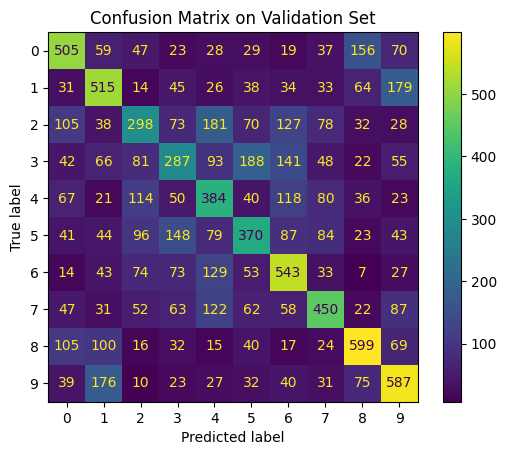

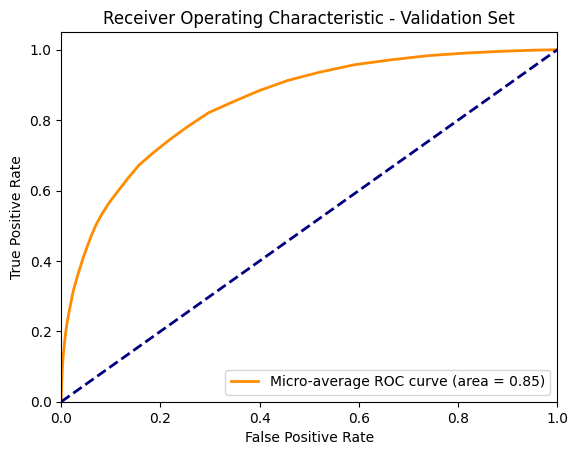

In [ ]:
# Predict on the validation set
y_val_pred = random_forest.predict(X_val_flat)
y_val_pred_prob = random_forest.predict_proba(X_val_flat)

# Evaluate the model
print("Classification Report on Validation Set:")
print(classification_report(y_val.argmax(axis=1), y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val.argmax(axis=1), y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot()
plt.title("Confusion Matrix on Validation Set")
plt.show()

# ROC-AUC Score and Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_val_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=2, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Validation Set')
plt.legend(loc="lower right")
plt.show()

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      1000
           1       0.51      0.55      0.53      1000
           2       0.36      0.31      0.34      1000
           3       0.35      0.28      0.31      1000
           4       0.38      0.39      0.39      1000
           5       0.42      0.39      0.40      1000
           6       0.46      0.53      0.49      1000
           7       0.50      0.44      0.47      1000
           8       0.58      0.62      0.60      1000
           9       0.48      0.54      0.51      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000
weighted avg       0.46      0.46      0.46     10000



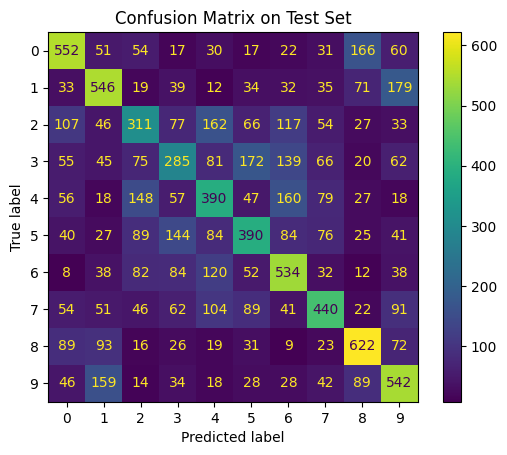

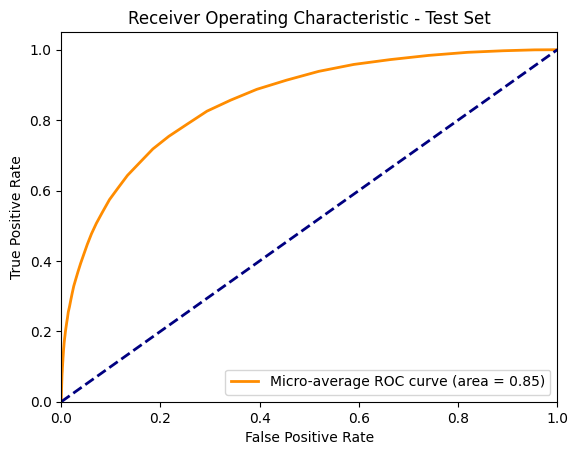

In [ ]:
# Predict on the test set
y_test_pred = random_forest.predict(X_test_flat)
y_test_pred_prob = random_forest.predict_proba(X_test_flat)

# Evaluate the model
print("Classification Report on Test Set:")
print(classification_report(y_test.argmax(axis=1), y_test_pred))

# Confusion Matrix
cm_test = confusion_matrix(y_test.argmax(axis=1), y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=range(10))
disp_test.plot()
plt.title("Confusion Matrix on Test Set")
plt.show()

# ROC-AUC Score and Curve
fpr_rf_cifar = {}
tpr_rf_cifar = {}
roc_auc = {}

for i in range(10):
    fpr_rf_cifar[i], tpr_rf_cifar[i], _ = roc_curve(y_test[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr_rf_cifar[i], tpr_rf_cifar[i])

# Computing micro-average ROC curve and ROC area
fpr_rf_cifar["micro"], tpr_rf_cifar["micro"], _ = roc_curve(y_test.ravel(), y_test_pred_prob.ravel())
roc_auc["micro"] = auc(fpr_rf_cifar["micro"], tpr_rf_cifar["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr_rf_cifar["micro"], tpr_rf_cifar["micro"], color='darkorange', lw=2, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc="lower right")
plt.show()

### e. xgBoost on CIFAR-10

In [ ]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Flatten the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Further split the training set into training and validation sets
X_train_flat, X_val_flat, y_train, y_val = train_test_split(X_train_flat, y_train, test_size=0.2, random_state=42)

# Convert the target variables to integer labels
y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()

In [ ]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=10, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Train the model
xgb_model.fit(X_train_flat, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=10, num_parallel_tree=None, ...)

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       973
           1       0.63      0.61      0.62       979
           2       0.45      0.39      0.42      1030
           3       0.40      0.40      0.40      1023
           4       0.44      0.46      0.45       933
           5       0.44      0.42      0.43      1015
           6       0.54      0.64      0.59       996
           7       0.59      0.55      0.57       994
           8       0.67      0.67      0.67      1017
           9       0.59      0.61      0.60      1040

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000



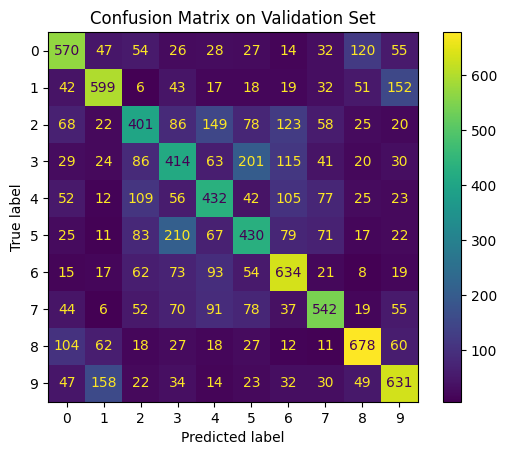

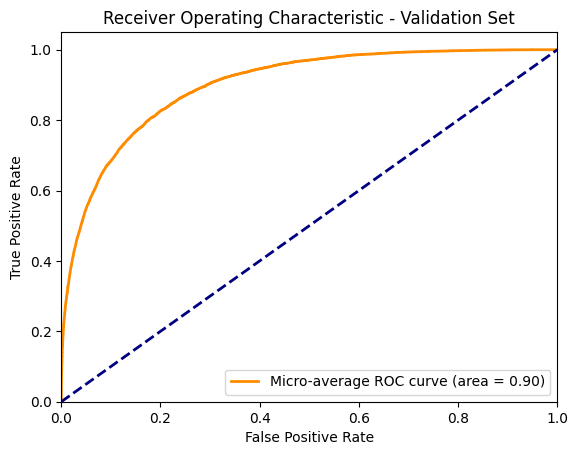

In [ ]:
# Predict on the validation set
y_val_pred = xgb_model.predict(X_val_flat)
y_val_pred_prob = xgb_model.predict_proba(X_val_flat)

# Classification Report
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot()
plt.title("Confusion Matrix on Validation Set")
plt.show()

# ROC-AUC Score and Curve
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_val == i, y_val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
y_val_binarized = label_binarize(y_val, classes=range(10))
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_binarized.ravel(), y_val_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=2, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Validation Set')
plt.legend(loc="lower right")
plt.show()

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      1000
           1       0.66      0.61      0.63      1000
           2       0.45      0.42      0.43      1000
           3       0.36      0.35      0.36      1000
           4       0.47      0.45      0.46      1000
           5       0.46      0.45      0.45      1000
           6       0.54      0.65      0.59      1000
           7       0.60      0.56      0.58      1000
           8       0.65      0.68      0.66      1000
           9       0.58      0.61      0.60      1000

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.54     10000
weighted avg       0.54      0.54      0.54     10000



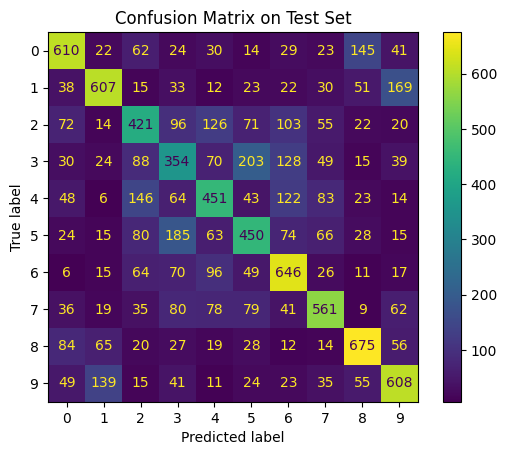

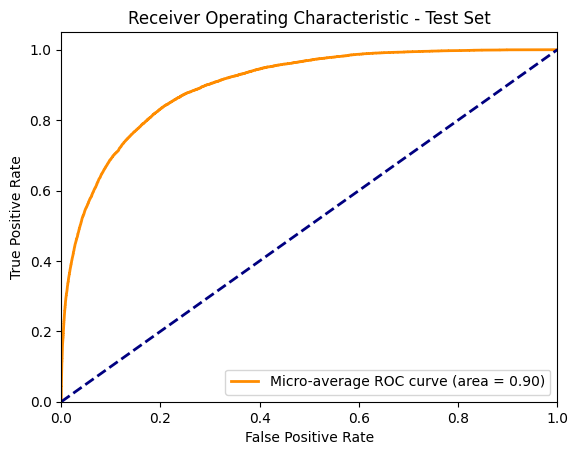

In [ ]:
# Predict on the test set
y_test_pred = xgb_model.predict(X_test_flat)
y_test_pred_prob = xgb_model.predict_proba(X_test_flat)

# Classification Report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot()
plt.title("Confusion Matrix on Test Set")
plt.show()

# ROC-AUC Score and Curve
# Compute ROC curve and ROC area for each class
fpr_xgb_cifar = dict()
tpr_xgb_cifar = dict()
roc_auc = dict()
for i in range(10):
    fpr_xgb_cifar[i], tpr_xgb_cifar[i], _ = roc_curve(y_test == i, y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr_xgb_cifar[i], tpr_xgb_cifar[i])

# Compute micro-average ROC curve and ROC area
y_test_binarized = label_binarize(y_test, classes=range(10))
fpr_xgb_cifar["micro"], tpr_xgb_cifar["micro"], _ = roc_curve(y_test_binarized.ravel(), y_test_pred_prob.ravel())
roc_auc["micro"] = auc(fpr_xgb_cifar["micro"], tpr_xgb_cifar["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr_xgb_cifar["micro"], tpr_xgb_cifar["micro"], color='darkorange', lw=2, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc="lower right")
plt.show()

## 3. Comparing ML models on Chemical Bonds dataset

### a. Installing dependencies

In [ ]:
pip install git+https://github.com/yuce/pyswip@master#egg=pyswip

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/yuce/pyswip (to revision master) to /tmp/pip-install-0vifi9jn/pyswip_4e6c02974d7048b4b0334731df2e5d5e
  Running command git clone --filter=blob:none --quiet https://github.com/yuce/pyswip /tmp/pip-install-0vifi9jn/pyswip_4e6c02974d7048b4b0334731df2e5d5e
  Resolved https://github.com/yuce/pyswip to commit 8eec0917c79f9414749252f0e57212c09ecdeaf9
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


### b. Implementing ILP on Chemical Bonds Dataset

In [ ]:
from  PyILP.PyILP import *
model_aleph=aleph_learn(file="chem_bonds_bk_aleph.pl", positive_example="pos_example.f", negative_example="neg_example.n", test_size=0, settings='modes.pl')

ERROR: /user/HS401/sk02593/Desktop/ml-couursework/aleph_bk_1.pl:23:
ERROR:    No permission to modify static procedure `atom/1'
ERROR: /user/HS401/sk02593/Desktop/ml-couursework/aleph_bk_1.pl:24:
ERROR:    No permission to modify static procedure `atom/1'
ERROR: /user/HS401/sk02593/Desktop/ml-couursework/aleph_bk_1.pl:25:
ERROR:    No permission to modify static procedure `atom/1'
ERROR: /user/HS401/sk02593/Desktop/ml-couursework/aleph_bk_1.pl:26:
ERROR:    No permission to modify static procedure `atom/1'
ERROR: /user/HS401/sk02593/Desktop/ml-couursework/aleph_bk_1.pl:27:
ERROR:    No permission to modify static procedure `atom/1'
ERROR: /user/HS401/sk02593/Desktop/ml-couursework/aleph_bk_1.pl:28:
ERROR:    No permission to modify static procedure `atom/1'
ERROR: /user/HS401/sk02593/Desktop/ml-couursework/aleph_bk_1.pl:29:
ERROR:    No permission to modify static procedure `atom/1'
ERROR: /user/HS401/sk02593/Desktop/ml-couursework/aleph_bk_1.pl:30:
ERROR:    No permission to modify st

[]
+----------+ Learning +----------+


ERROR: /user/HS401/sk02593/Desktop/ml-couursework/copy_bk.pl:5:
ERROR:    No permission to modify static procedure `atom/1'
ERROR: /user/HS401/sk02593/Desktop/ml-couursework/copy_bk.pl:6:
ERROR:    No permission to modify static procedure `atom/1'
ERROR: /user/HS401/sk02593/Desktop/ml-couursework/copy_bk.pl:7:
ERROR:    No permission to modify static procedure `atom/1'
ERROR: /user/HS401/sk02593/Desktop/ml-couursework/copy_bk.pl:8:
ERROR:    No permission to modify static procedure `atom/1'
ERROR: /user/HS401/sk02593/Desktop/ml-couursework/copy_bk.pl:9:
ERROR:    No permission to modify static procedure `atom/1'
ERROR: /user/HS401/sk02593/Desktop/ml-couursework/copy_bk.pl:10:
ERROR:    No permission to modify static procedure `atom/1'
ERROR: /user/HS401/sk02593/Desktop/ml-couursework/copy_bk.pl:11:
ERROR:    No permission to modify static procedure `atom/1'
ERROR: /user/HS401/sk02593/Desktop/ml-couursework/copy_bk.pl:12:
ERROR:    No permission to modify static procedure `atom/1'
ERROR

+---------------------+------------------+------------------+
|       n = 37        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 19               | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 18               |
+---------------------+------------------+------------------+
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+-------------+---+


ERROR: /user/HS401/sk02593/Desktop/ml-couursework/copy_bk.pl:73:
ERROR:    assertz/1: No permission to modify static procedure `bond/3'
ERROR:    Defined at /user/HS401/sk02593/Desktop/ml-couursework/aleph_bk_1.pl:74


### c. Generating a Syntheic Dataset for Chemical Bonds

In [2]:
# Creating a synthetic dataset
np.random.seed(42)

num_samples = 1000
atoms = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca']
bond_types = ['single', 'double', 'triple', 'ionic', 'covalent']

# Generating random samples
data = {
    'atom1': np.random.choice(atoms, num_samples),
    'atom2': np.random.choice(atoms, num_samples),
    'bond_type': np.random.choice(bond_types, num_samples),
    'feature1': np.random.rand(num_samples),
    'feature2': np.random.rand(num_samples),
    'feature3': np.random.rand(num_samples),
    'label': np.random.choice([0, 1], num_samples)
}

df = pd.DataFrame(data)

# Encoding categorical variables
le_atom = LabelEncoder()
df['atom1'] = le_atom.fit_transform(df['atom1'])
df['atom2'] = le_atom.fit_transform(df['atom2'])
le_bond = LabelEncoder()
df['bond_type'] = le_bond.fit_transform(df['bond_type'])

# Splitting the data
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### d. Naive Bayes for Synthetic Chemical Bonds Dataset

In [3]:
# Initialize and train Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test)
y_pred_nb_prob = nb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Naive Bayes Classification Report")
print(classification_report(y_test, y_pred_nb))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_nb))

# ROC-AUC
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb_prob)
roc_auc_nb = roc_auc_score(y_test, y_pred_nb_prob)
print(f"Naive Bayes ROC-AUC: {roc_auc_nb:.2f}")

Naive Bayes Classification Report
              precision    recall  f1-score   support

           0       0.47      0.41      0.44       101
           1       0.47      0.54      0.50        99

    accuracy                           0.47       200
   macro avg       0.47      0.47      0.47       200
weighted avg       0.47      0.47      0.47       200

Confusion Matrix
[[41 60]
 [46 53]]
Naive Bayes ROC-AUC: 0.46


### e. Random Forest on Synthetic Chemical Bonds Dataset

In [4]:
# Initialize and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Random Forest Classification Report")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_rf))

# ROC-AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf_prob)
print(f"Random Forest ROC-AUC: {roc_auc_rf:.2f}")

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.46      0.47      0.46       101
           1       0.44      0.43      0.44        99

    accuracy                           0.45       200
   macro avg       0.45      0.45      0.45       200
weighted avg       0.45      0.45      0.45       200

Confusion Matrix
[[47 54]
 [56 43]]
Random Forest ROC-AUC: 0.46


### f. CNN on Synthetic Chemical Bonds Dataset

In [5]:
# Reshape data to fit CNN model
X_train_cnn = X_train.reshape(X_train.shape[0], 2, 3, 1)
X_test_cnn = X_test.reshape(X_test.shape[0], 2, 3, 1)

# Initialize and train CNN model
cnn_model = Sequential([
    Conv2D(16, kernel_size=(2, 2), activation='relu', input_shape=(2, 3, 1)),
    MaxPooling2D(pool_size=(1, 1)),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test))

# Evaluate the model
cnn_eval = cnn_model.evaluate(X_test_cnn, y_test)
y_pred_cnn_prob = cnn_model.predict(X_test_cnn).ravel()
print(f"CNN Model Accuracy: {cnn_eval[1] * 100:.2f}%")

# ROC-AUC
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_cnn_prob)
roc_auc_cnn = roc_auc_score(y_test, y_pred_cnn_prob)
print(f"CNN ROC-AUC: {roc_auc_cnn:.2f}")

Epoch 1/10
25/25 [==============================] - 11s 50ms/step - loss: 0.7065 - accuracy: 0.5150 - val_loss: 0.6918 - val_accuracy: 0.5250
Epoch 2/10
25/25 [==============================] - 0s 8ms/step - loss: 0.7072 - accuracy: 0.4963 - val_loss: 0.6920 - val_accuracy: 0.5200
Epoch 3/10
25/25 [==============================] - 0s 8ms/step - loss: 0.7021 - accuracy: 0.5138 - val_loss: 0.6923 - val_accuracy: 0.5150
Epoch 4/10
25/25 [==============================] - 0s 7ms/step - loss: 0.7013 - accuracy: 0.4800 - val_loss: 0.6918 - val_accuracy: 0.5150
Epoch 5/10
25/25 [==============================] - 0s 7ms/step - loss: 0.6896 - accuracy: 0.5275 - val_loss: 0.6930 - val_accuracy: 0.5150
Epoch 6/10
25/25 [==============================] - 0s 9ms/step - loss: 0.6958 - accuracy: 0.4950 - val_loss: 0.6934 - val_accuracy: 0.5400
Epoch 7/10
25/25 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5300 - val_loss: 0.6939 - val_accuracy: 0.5250
Epoch 8/10
25/25 [

### g. XgBoost on Synthetic Chemical Bonds Dataset

In [6]:
# Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("XGBoost Classification Report")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_xgb))

# ROC-AUC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb_prob)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb_prob)
print(f"XGBoost ROC-AUC: {roc_auc_xgb:.2f}")

XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.49      0.44      0.46       101
           1       0.48      0.54      0.51        99

    accuracy                           0.48       200
   macro avg       0.49      0.49      0.48       200
weighted avg       0.49      0.48      0.48       200

Confusion Matrix
[[44 57]
 [46 53]]
XGBoost ROC-AUC: 0.48


### h. Evaluating Non-relational ML models on Relational Dataset

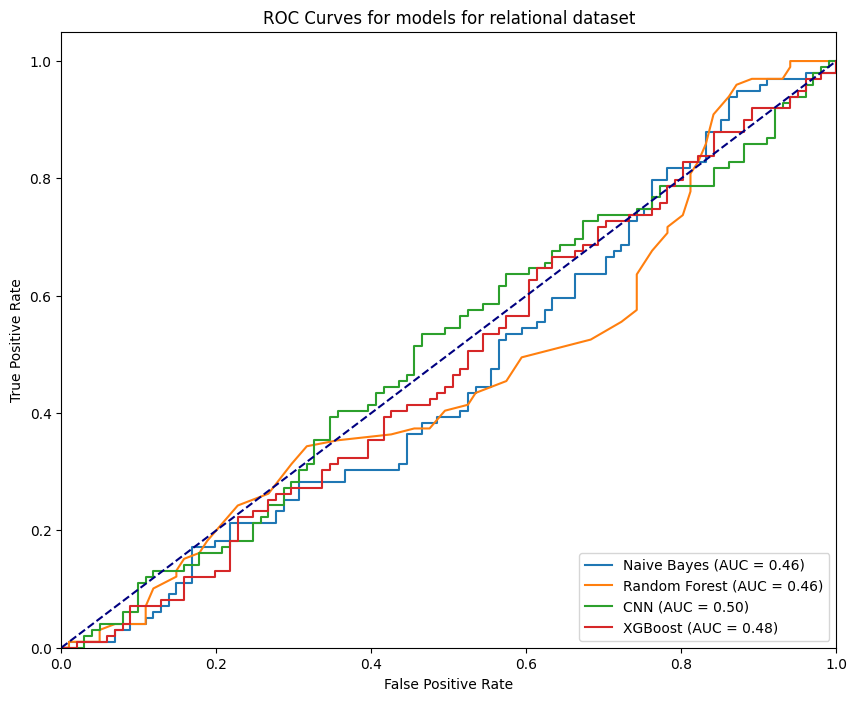

In [8]:
def plot_roc_curves(models_fpr_tpr, title='ROC Curves for models for relational dataset'):
    plt.figure(figsize=(10, 8))
    for model_name, (fpr, tpr, auc_score) in models_fpr_tpr.items():
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

models_fpr_tpr = {
    'Naive Bayes': (fpr_nb, tpr_nb, roc_auc_nb),
    'Random Forest': (fpr_rf, tpr_rf, roc_auc_rf),
    'CNN': (fpr_cnn, tpr_cnn, roc_auc_cnn),
    'XGBoost': (fpr_xgb, tpr_xgb, roc_auc_xgb)
}

plot_roc_curves(models_fpr_tpr)

## Evaluation

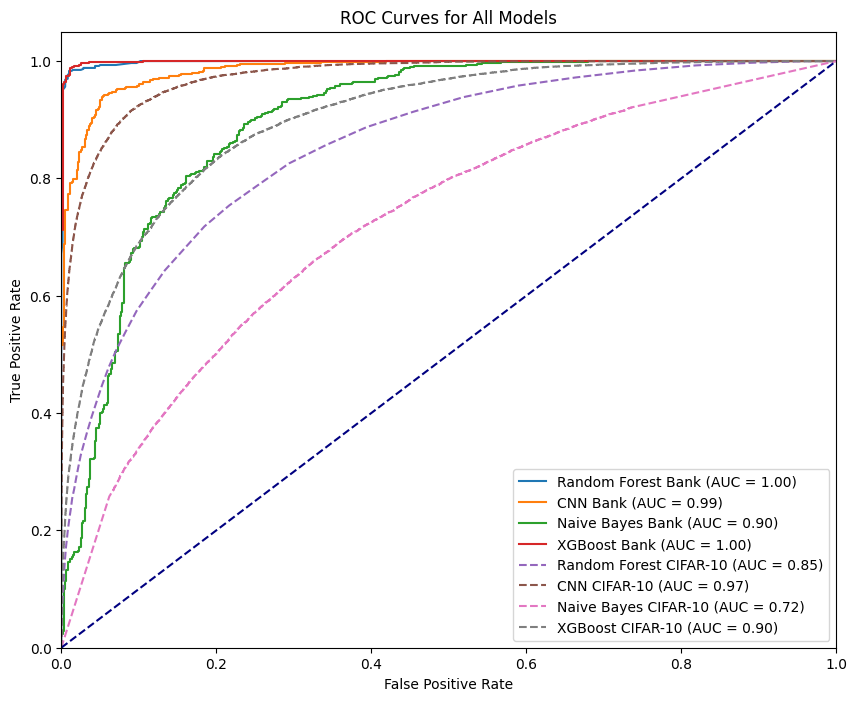

In [ ]:
def plot_roc_curves(models_fpr_tpr, multi_class_fpr_tpr, title='ROC Curves for All Models'):
    plt.figure(figsize=(10, 8))

    # Plot binary classification ROC curves
    for model_name, (fpr, tpr) in models_fpr_tpr.items():
        fpr = np.array(fpr).flatten()
        tpr = np.array(tpr).flatten()
        if len(fpr) > 1 and len(tpr) > 1:
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc(fpr, tpr):.2f})')
        else:
            print(f"Skipping {model_name}: Not enough points for ROC curve.")

    # Plot multi-class classification ROC curves using micro-average
    for model_name, (fpr, tpr) in multi_class_fpr_tpr.items():
        fpr = np.array(fpr).flatten()
        tpr = np.array(tpr).flatten()
        if len(fpr) > 1 and len(tpr) > 1:
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc(fpr, tpr):.2f})', linestyle='--')
        else:
            print(f"Skipping {model_name}: Not enough points for ROC curve.")

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

models_fpr_tpr = {
    'Random Forest Bank': (fpr_rf_bank, tpr_rf_bank),
    'CNN Bank': (fpr_cnn_bank, tpr_cnn_bank),
    'Naive Bayes Bank': (fpr_nb_bank, tpr_nb_bank),
    'XGBoost Bank': (fpr_xgb_bank, tpr_xgb_bank)
}

multi_class_fpr_tpr = {
    'Random Forest CIFAR-10': (fpr_rf_cifar["micro"], tpr_rf_cifar["micro"]),
    'CNN CIFAR-10': (fpr_cnn_cifar["micro"], tpr_cnn_cifar["micro"]),
    'Naive Bayes CIFAR-10': (fpr_nb_cifar["micro"], tpr_nb_cifar["micro"]),
    'XGBoost CIFAR-10': (fpr_xgb_cifar["micro"], tpr_xgb_cifar["micro"])
}

plot_roc_curves(models_fpr_tpr, multi_class_fpr_tpr)